In [1]:
import pandas as pd

# 1) Load your regression output
reg = pd.read_csv("regression_results.csv")

# 2) Quick sanity checks
print("Shape:", reg.shape)           # how many rows × columns?
print("Columns:", reg.columns.tolist())  
reg.head()                           # peek at the first 5 lines


Shape: (56848, 5)
Columns: ['Unnamed: 0', 'gene', 'peak_ID', 'coefficient', 'r2']


,Unnamed: 0,gene,peak_ID,coefficient,r2
0,0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561
1,1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538
2,2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538
3,3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855


In [8]:
annot = pd.read_csv("peaks_tss_distance.csv")
print("Annot shape:", annot.shape)
print("Annot cols:",  annot.columns.tolist())
annot.head()


Annot shape: (75857, 5)
Annot cols: ['ImmGenATAC1219.peakID', 'chrom', 'peak_center', 'closest_tss', 'distance_to_tss']


,ImmGenATAC1219.peakID,chrom,peak_center,closest_tss,distance_to_tss
0,ImmGenATAC1219.peak_69,chr1,4468579,4497354.0,28775.0
1,ImmGenATAC1219.peak_77,chr1,4490652,4497354.0,6702.0
2,ImmGenATAC1219.peak_83,chr1,4496479,4497354.0,875.0
3,ImmGenATAC1219.peak_84,chr1,4496738,4497354.0,616.0
4,ImmGenATAC1219.peak_93,chr1,4547574,4497354.0,50220.0


In [6]:
# try a few relaxed cutoffs
for cutoff in [0.75, 0.7, 0.5, 0.2, 0.1, 0.05]:
    kept = (reg.r2 >= cutoff).sum()
    pct  = kept / len(reg) * 100
    print(f"R² ≥ {cutoff:<4} → {kept:5d} links ({pct:4.1f} %)")


R² ≥ 0.75 → 24816 links (43.7 %)
R² ≥ 0.7  → 28746 links (50.6 %)
R² ≥ 0.5  → 41710 links (73.4 %)
R² ≥ 0.2  → 52155 links (91.7 %)
R² ≥ 0.1  → 54249 links (95.4 %)
R² ≥ 0.05 → 55315 links (97.3 %)


In [25]:
import pandas as pd

# your regression results
reg = pd.read_csv("regression_results.csv")

# your TSS–distance lookup
dist = pd.read_csv("peaks_tss_distance.csv")

dist = dist.rename(columns={"ImmGenATAC1219.peakID": "peak_ID"})


In [26]:
reg2 = reg.merge(
    dist[["peak_ID","distance_to_tss"]],
    on="peak_ID",
    how="left",
    validate="m:1"   # many reg rows → one dist row
)


In [27]:
n_missing = reg2["distance_to_tss"].isna().sum()
print(f"{n_missing} links have no distance; all others got filled in.")


0 links have no distance; all others got filled in.


In [28]:
print(reg2.shape)        # should be same # rows as reg
reg2.head()


(56848, 6)


,Unnamed: 0,gene,peak_ID,coefficient,r2,distance_to_tss
0,0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561,6702.0
1,1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538,6702.0
2,2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538,875.0
3,3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538,74643.0
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855,10510.0


In [40]:
# 1) apply your R² cutoff
high_conf = reg2[reg2["r2"] >= 0.7].copy()

# 2) how many remain?
print(f"{len(high_conf)} links out of {len(reg2)} pass R² ≥ 0.7")

# 3) peek at them
high_conf.head(10)


28746 links out of 56848 pass R² ≥ 0.7


,Unnamed: 0,gene,peak_ID,coefficient,r2,distance_to_tss
13,13,Pcmtd1,ImmGenATAC1219.peak_376,-1.367742,0.752231,394.0
14,14,Pcmtd1,ImmGenATAC1219.peak_377,-2.494725,0.752231,144.0
15,15,Pcmtd1,ImmGenATAC1219.peak_378,3.276884,0.752231,132.0
16,16,Pcmtd1,ImmGenATAC1219.peak_380,5.020475,0.752231,7143.0
17,17,Pcmtd1,ImmGenATAC1219.peak_408,0.983100,0.752231,58306.0
18,18,Pcmtd1,ImmGenATAC1219.peak_413,7.729939,0.752231,75027.0
22,22,Sgk3,ImmGenATAC1219.peak_577,-0.586173,0.820577,93.0
23,23,Sgk3,ImmGenATAC1219.peak_594,3.325265,0.820577,81.0
24,24,Sgk3,ImmGenATAC1219.peak_601,13.819465,0.820577,8000.0
25,25,Sgk3,ImmGenATAC1219.peak_602,7.729455,0.820577,9691.0


In [49]:
# 1) start from your high‐confidence links (R² ≥ 0.7)
#    assume you already have:
#       high_conf = reg2[reg2["r2"] >= 0.7].copy()

# 2) find, for each gene, the promoter peak
#    (i.e. among positive‐coef peaks, the one with smallest distance_to_tss)
pos = high_conf[high_conf["coefficient"] > 0]
promoter_idx = pos.groupby("gene")["distance_to_tss"].idxmin()
promoters = pos.loc[promoter_idx, ["gene", "peak_ID"]]
promoter_map = promoters.set_index("gene")["peak_ID"].to_dict()

# 3) assign role to every link
def assign_role(row):
    gene = row["gene"]
    peak = row["peak_ID"]
    coef = row["coefficient"]
    if peak == promoter_map.get(gene):
        return "promoter"
    elif coef > 0:
        return "activator"
    else:
        return "repressor"

high_conf["role"] = high_conf.apply(assign_role, axis=1)

# 4) preview
high_conf[["gene","peak_ID","coefficient","r2","distance_to_tss","role"]].head(20)


,gene,peak_ID,coefficient,r2,distance_to_tss,role
13,Pcmtd1,ImmGenATAC1219.peak_376,-1.367742,0.752231,394.0,repressor
14,Pcmtd1,ImmGenATAC1219.peak_377,-2.494725,0.752231,144.0,repressor
15,Pcmtd1,ImmGenATAC1219.peak_378,3.276884,0.752231,132.0,promoter
16,Pcmtd1,ImmGenATAC1219.peak_380,5.020475,0.752231,7143.0,activator
17,Pcmtd1,ImmGenATAC1219.peak_408,0.983100,0.752231,58306.0,activator
18,Pcmtd1,ImmGenATAC1219.peak_413,7.729939,0.752231,75027.0,activator
22,Sgk3,ImmGenATAC1219.peak_577,-0.586173,0.820577,93.0,repressor
23,Sgk3,ImmGenATAC1219.peak_594,3.325265,0.820577,81.0,activator
24,Sgk3,ImmGenATAC1219.peak_601,13.819465,0.820577,8000.0,activator
25,Sgk3,ImmGenATAC1219.peak_602,7.729455,0.820577,9691.0,activator


In [50]:
# filter for Ltb
ltb = high_conf[high_conf["gene"] == "Ltb"]

# select the columns we care about
ltb[["peak_ID","distance_to_tss","coefficient","r2","role"]]


,peak_ID,distance_to_tss,coefficient,r2,role
22173,ImmGenATAC1219.peak_213552,242.0,-3.520328,0.893846,repressor
22174,ImmGenATAC1219.peak_213561,2561.0,-39.880566,0.893846,repressor
22175,ImmGenATAC1219.peak_213568,4222.0,8.742759,0.893846,activator
22176,ImmGenATAC1219.peak_213574,1623.0,75.062982,0.893846,activator
22177,ImmGenATAC1219.peak_213584,135.0,69.126157,0.893846,activator
22178,ImmGenATAC1219.peak_213585,131.0,10.576468,0.893846,activator
22179,ImmGenATAC1219.peak_213588,855.0,-28.484788,0.893846,repressor
22180,ImmGenATAC1219.peak_213591,1343.0,-1.519843,0.893846,repressor
22181,ImmGenATAC1219.peak_213603,5029.0,13.044219,0.893846,activator
22182,ImmGenATAC1219.peak_213620,3762.0,8.489428,0.893846,activator


In [54]:
# 1) Assuming you already have ‘high_conf’ from:
#    high_conf = reg2[reg2["r2"] >= 0.7].copy()

# 2) Just tally up the roles:
role_counts = high_conf["role"].value_counts().rename_axis("role").reset_index(name="count")
print(role_counts)


        role  count
0  repressor  13025
1  activator  12707
2   promoter   3014


In [70]:
# 1) Filter for promoters
promoters = high_conf[high_conf["role"] == "promoter"].copy()

# 2) Peek at the first 20 promoter links
print(promoters[["gene","peak_ID","distance_to_tss"]].head(20))

# 3) Get summary statistics on their distances
print(promoters["distance_to_tss"].describe())


         gene                   peak_ID  distance_to_tss
15     Pcmtd1   ImmGenATAC1219.peak_378            132.0
28       Sgk3   ImmGenATAC1219.peak_623             16.0
47    Arfgef1   ImmGenATAC1219.peak_720           7046.0
80       Eya1  ImmGenATAC1219.peak_1471             92.0
88     Sbspon  ImmGenATAC1219.peak_1657             59.0
102     Stau2  ImmGenATAC1219.peak_1805            341.0
115   Gm16070  ImmGenATAC1219.peak_1988             63.0
116  Crispld1  ImmGenATAC1219.peak_1985           8414.0
126      Mcm3  ImmGenATAC1219.peak_2124             36.0
134     Paqr8  ImmGenATAC1219.peak_2124             36.0
161     Kcnq5  ImmGenATAC1219.peak_2447            632.0
167    Ogfrl1  ImmGenATAC1219.peak_2558            220.0
176     Smap1  ImmGenATAC1219.peak_2659            278.0
227    Ptpn18  ImmGenATAC1219.peak_3481             48.0
250      Cfc1  ImmGenATAC1219.peak_3481             48.0
265   Plekhb2  ImmGenATAC1219.peak_3632             13.0
289    Arid5a  ImmGenATAC1219.p

In [71]:
# Sort by distance, descending
print(promoters[["gene","peak_ID","distance_to_tss"]]
      .sort_values("distance_to_tss", ascending=False)
      .head(10))


                gene                     peak_ID  distance_to_tss
26193         Mamdc2  ImmGenATAC1219.peak_248648          79408.0
51068         Rnf150  ImmGenATAC1219.peak_463338          76793.0
31295        Fam217b  ImmGenATAC1219.peak_297365          75720.0
12413         Dio3os  ImmGenATAC1219.peak_115854          71897.0
16769            Ghr  ImmGenATAC1219.peak_164962          71438.0
8268           Wscd1   ImmGenATAC1219.peak_80643          69999.0
50237          Hmgb2  ImmGenATAC1219.peak_458765          68203.0
16696          Farp1  ImmGenATAC1219.peak_163849          67147.0
5992   9230105E05Rik   ImmGenATAC1219.peak_63516          65501.0
26307           Gldc  ImmGenATAC1219.peak_250056          61987.0


In [72]:
# assume `high_conf` is your R² ≥ 0.7 table with 'role' and 'distance_to_tss'

# 1) Boolean mask for far-away promoters
far_promoters = (high_conf["role"] == "promoter") & (high_conf["distance_to_tss"] > 1000)

# 2) Remove them from the high_conf table
high_conf_filtered = high_conf[~far_promoters].copy()

# 3) Quick sanity check:
print(f"Removed {far_promoters.sum()} promoters >1 kb away")
print("Remaining promoters:")
print(high_conf_filtered[high_conf_filtered["role"]=="promoter"]["distance_to_tss"].describe())

# high_conf_filtered now has no promoters farther than 1 kb


Removed 524 promoters >1 kb away
Remaining promoters:
count    2490.000000
mean      102.701205
std       155.703767
min         0.000000
25%        18.000000
50%        44.000000
75%       106.000000
max       990.000000
Name: distance_to_tss, dtype: float64


Wrote high_conf_filtered.csv — 28222 rows


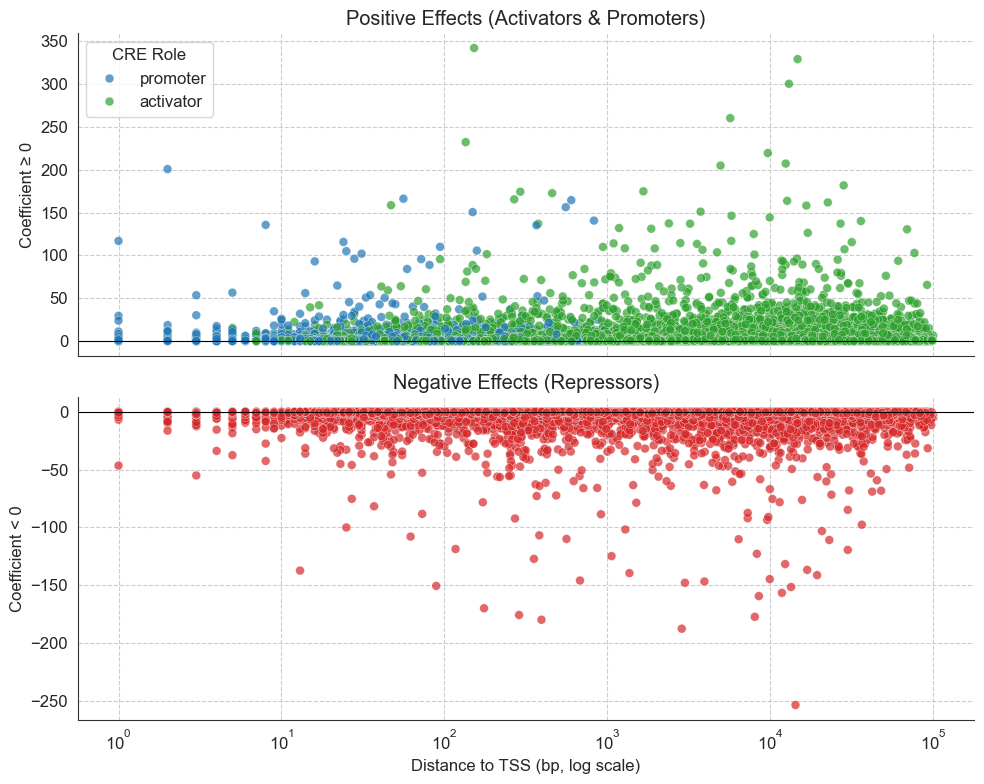

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) save to disk
high_conf_filtered.to_csv("high_conf_filtered.csv", index=False)
print("Wrote high_conf_filtered.csv —", high_conf_filtered.shape[0], "rows")

import matplotlib.pyplot as plt
import seaborn as sns

# 1) Set a minimalist style
sns.set_style("whitegrid", {
    "grid.color":      "#cccccc",
    "grid.linestyle":  "--",
    "axes.edgecolor":  "#333333",
    "axes.linewidth":  1.0,
})
plt.rc("font", family="sans-serif", size=12)

# 2) Prepare the data: split activators vs repressors/promoters
pos = high_conf_filtered[high_conf_filtered["coefficient"] >= 0]
neg = high_conf_filtered[high_conf_filtered["coefficient"] <  0]

# 3) Create two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(10, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1]}
)

# 4) Plot positive coefficients (activators + promoters)
sns.scatterplot(
    data=pos,
    x="distance_to_tss", y="coefficient",
    hue="role",
    palette={"activator":"#2ca02c", "promoter":"#1f77b4"},
    edgecolor="w", linewidth=0.3,
    alpha=0.7,
    s=40,
    ax=ax1
)
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_title("Positive Effects (Activators & Promoters)")
ax1.set_ylabel("Coefficient ≥ 0")
ax1.legend(title="CRE Role", loc="upper left")

# 5) Plot negative coefficients (repressors only)
sns.scatterplot(
    data=neg,
    x="distance_to_tss", y="coefficient",
    hue="role",
    palette={"repressor":"#d62728"},
    edgecolor="w", linewidth=0.3,
    alpha=0.7,
    s=40,
    ax=ax2,
    legend=False
)
ax2.axhline(0, color="black", linewidth=0.8)
ax2.set_title("Negative Effects (Repressors)")
ax2.set_ylabel("Coefficient < 0")
ax2.set_xlabel("Distance to TSS (bp, log scale)")

# 6) Final tweaks
for ax in (ax1, ax2):
    ax.set_xscale("log")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [76]:
# write to your Desktop
high_conf_filtered.to_csv("~/Desktop/high_conf_filtered.csv", index=False)
print("Wrote ~/Desktop/high_conf_filtered.csv —", high_conf_filtered.shape[0], "rows")


Wrote ~/Desktop/high_conf_filtered.csv — 28222 rows


In [78]:
import pandas as pd

# 1) Most repressive “repressor”
most_repressive = (
    high_conf[high_conf.role == "repressor"]
     .nsmallest(1, "coefficient")
     .loc[:, ["peak_ID","gene","distance_to_tss","coefficient"]]
)
print("Most repressive repressor:\n", most_repressive)

# 2) Genes with all three roles
roles_per_gene = high_conf.groupby("gene")["role"] \
                          .unique().apply(set)
n_all3 = sum(1 for roles in roles_per_gene
             if {"promoter","activator","repressor"}.issubset(roles))
print(f"Genes with all 3 roles: {n_all3}")

# 3) Genes with only a promoter
n_only_prom = sum(1 for roles in roles_per_gene
                  if roles == {"promoter"})
print(f"Genes with only promoter: {n_only_prom}")

# 4) Average counts of promoters & enhancers per gene
counts = high_conf.groupby("gene")["role"] \
                  .value_counts() \
                  .unstack(fill_value=0)
avg_prom  = counts["promoter"].mean()
avg_enh   = counts[["activator","repressor"]].sum(axis=1).mean()
print(f"Avg # promoters per gene: {avg_prom:.2f}")
print(f"Avg # enhancers per gene: {avg_enh:.2f}")


Most repressive repressor:
                         peak_ID  gene  distance_to_tss  coefficient
7311  ImmGenATAC1219.peak_75525  Tcf7          14254.0  -253.532701
Genes with all 3 roles: 2692
Genes with only promoter: 66
Avg # promoters per gene: 1.00
Avg # enhancers per gene: 8.51
